In [86]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

# Function to load data (images and labels)
def load_data(data_dir, img_size=(150, 150)):
    images = []
    labels = []
    
    for label, class_name in enumerate(["genuine", "forged"]):
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            img = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB by duplicating the channels
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Load data
X, y = load_data(r"C:\Users\kumar\Downloads\archive (1)\Dataset_Signature_Final\Dataset\dataset4")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Function to preprocess image (resize and normalize)
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Unable to load image at path: {image_path}")
    img = cv2.resize(img, (150, 150))
    img = img / 255.0  # Normalize to range [0, 1]
    img = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB by duplicating the channels
    img = img[np.newaxis, ...]  # Add batch dimension
    return img

# Create the Siamese model using ResNet50 for feature extraction
def create_siamese_model_with_resnet(input_shape=(150, 150, 3)):  # Now 3 channels for RGB
    # Load the ResNet50 model pre-trained on ImageNet, without the top (fully connected) layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the ResNet layers to prevent training them (feature extraction only)
    for layer in base_model.layers:
        layer.trainable = False

    # Input layers for the two images to compare
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    # Process both images through the base model (ResNet50)
    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    # Flatten the output from ResNet50
    processed_a = layers.Flatten()(processed_a)
    processed_b = layers.Flatten()(processed_b)

    # Add dense layers for further processing
    dense_layer = layers.Dense(128, activation='relu')
    processed_a = dense_layer(processed_a)
    processed_b = dense_layer(processed_b)

    # Compute Euclidean distance between the processed images
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_a, processed_b])

    # Output layer: A similarity score between 0 and 1
    output = layers.Dense(1, activation='sigmoid')(distance)

    # Create the model
    siamese_model = models.Model(inputs=[input_a, input_b], outputs=output)

    # Compile the model
    siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return siamese_model

# Create the Siamese model
model = create_siamese_model_with_resnet(input_shape=(150, 150, 3))  # Input shape should now be (150, 150, 3)

# Summary of the model
model.summary()

# Train the model
model.fit([X_train, X_train], y_train, epochs=10, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate([X_test, X_test], y_test)
print(f"Test accuracy: {test_acc}")



Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_38      │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 5, 5,      │ 23,587,712 │ input_layer_37[0… │
│ (Functional)        │ 2048)             │            │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_24          │ (None, 51200)     │          0 │ resnet50[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 51200)     │          0 │ resnet50[1][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │  6,553,728 │ flatten_24[0][0], │
│                     │                   │            │ flatten_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 128)       │          0 │ dense_24[0][0],   │
│                     │                   │            │ dense_24[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │        129 │ lambda_12[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,141,569 (114.98 MB)

 Trainable params: 6,553,857 (25.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.4504 - loss: 0.6932 - val_accuracy: 0.6667 - val_loss: 0.6931
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.4504 - loss: 0.6932 - val_accuracy: 0.3333 - val_loss: 0.6932
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 625ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.3333 - val_loss: 0.6932
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.3333 - val_loss: 0.6931
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 655ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.6667 - val_loss: 0.6931
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 657ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.6667 - val_loss: 0.6931
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 660ms/step - accuracy: 0.5104 - loss: 0.6931 - val_accuracy: 0.3333 - val_loss: 0.6932
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 680ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.3333 - val_loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Genuine Image: C:\Users\kumar\Downloads\archive (1)\Dataset_Signature_Final\Dataset\dataset3\genuine\02701027.png
Forged Image: C:\Users\kumar\Downloads\archive (1)\Dataset_Signature_Final\Dataset\dataset3\forged\00101014.png
Similarity Score: 0.2276


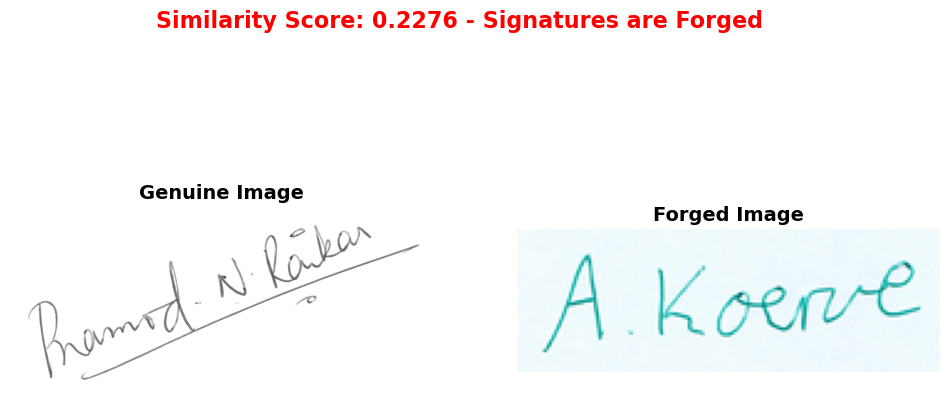

Signatures are not similar (Forged).
Overall genuine percentage: 0.00%
Pair 1: Signature is genuine: False


In [90]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to preprocess images
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150), color_mode="rgb")
    img_array = image.img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return preprocess_input(img_array)

# Function to verify signatures by comparing genuine and forged pairs
def verify_signature(model, genuine_dir, forged_dir, threshold=0.5):
    """
    Verifies if the signatures are genuine by comparing multiple genuine and forged signatures.
    """
    # Get list of images in the directories
    genuine_images = [os.path.join(genuine_dir, f) for f in os.listdir(genuine_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    forged_images = [os.path.join(forged_dir, f) for f in os.listdir(forged_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Ensure both directories have the same number of images
    min_length = min(len(genuine_images), len(forged_images))
    genuine_images = genuine_images[:min_length]
    forged_images = forged_images[:min_length]

    # Process each pair of images
    results = []
    for genuine_path, forged_path in zip(genuine_images, forged_images):
        # Preprocess images
        genuine_img = preprocess_image(genuine_path)
        forged_img = preprocess_image(forged_path)

        # Pass both images to the model at once (as a pair)
        prediction = model.predict([genuine_img, forged_img])[0][0]

        # Print the prediction for debugging
        print(f"Genuine Image: {genuine_path}")
        print(f"Forged Image: {forged_path}")
        print(f"Similarity Score: {prediction:.4f}")

        # Display images with result
        img1 = cv2.imread(genuine_path)
        img2 = cv2.imread(forged_path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        # Plot the images
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(img1)
        axes[0].axis('off')
        axes[0].set_title(f"Genuine Image", fontsize=14, fontweight='bold')

        axes[1].imshow(img2)
        axes[1].axis('off')
        axes[1].set_title(f"Forged Image", fontsize=14, fontweight='bold')

        # Display similarity result
        result_text = "Genuine" if prediction > threshold else "Forged"
        plt.suptitle(f"Similarity Score: {prediction:.4f} - Signatures are {result_text}", fontsize=16, fontweight='bold', color='green' if result_text == "Genuine" else 'red')

        plt.show()

        # If similarity score > threshold, classify as "Genuine", else "Forged"
        if prediction > threshold:
            print("Signatures are similar (Genuine).")
            results.append(True)
        else:
            print("Signatures are not similar (Forged).")
            results.append(False)

    # Return the overall result (e.g., percentage of genuine signatures)
    genuine_percentage = (sum(results) / len(results)) * 100
    print(f"Overall genuine percentage: {genuine_percentage:.2f}%")
    return results

# Example to verify signatures
genuine_dir = r"C:\Users\kumar\Downloads\archive (1)\Dataset_Signature_Final\Dataset\dataset3\genuine"
forged_dir = r"C:\Users\kumar\Downloads\archive (1)\Dataset_Signature_Final\Dataset\dataset3\forged"
results = verify_signature(model, genuine_dir, forged_dir)

# Print individual results
for i, result in enumerate(results):
    print(f"Pair {i + 1}: Signature is genuine: {result}")
